In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from data_wrangling.datamanager import DataLoader as DL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
dl = DL()

In [3]:
sessions = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's10']
data = dl.get_fcx2(sessions)
data.keys()

dict_keys(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's10'])

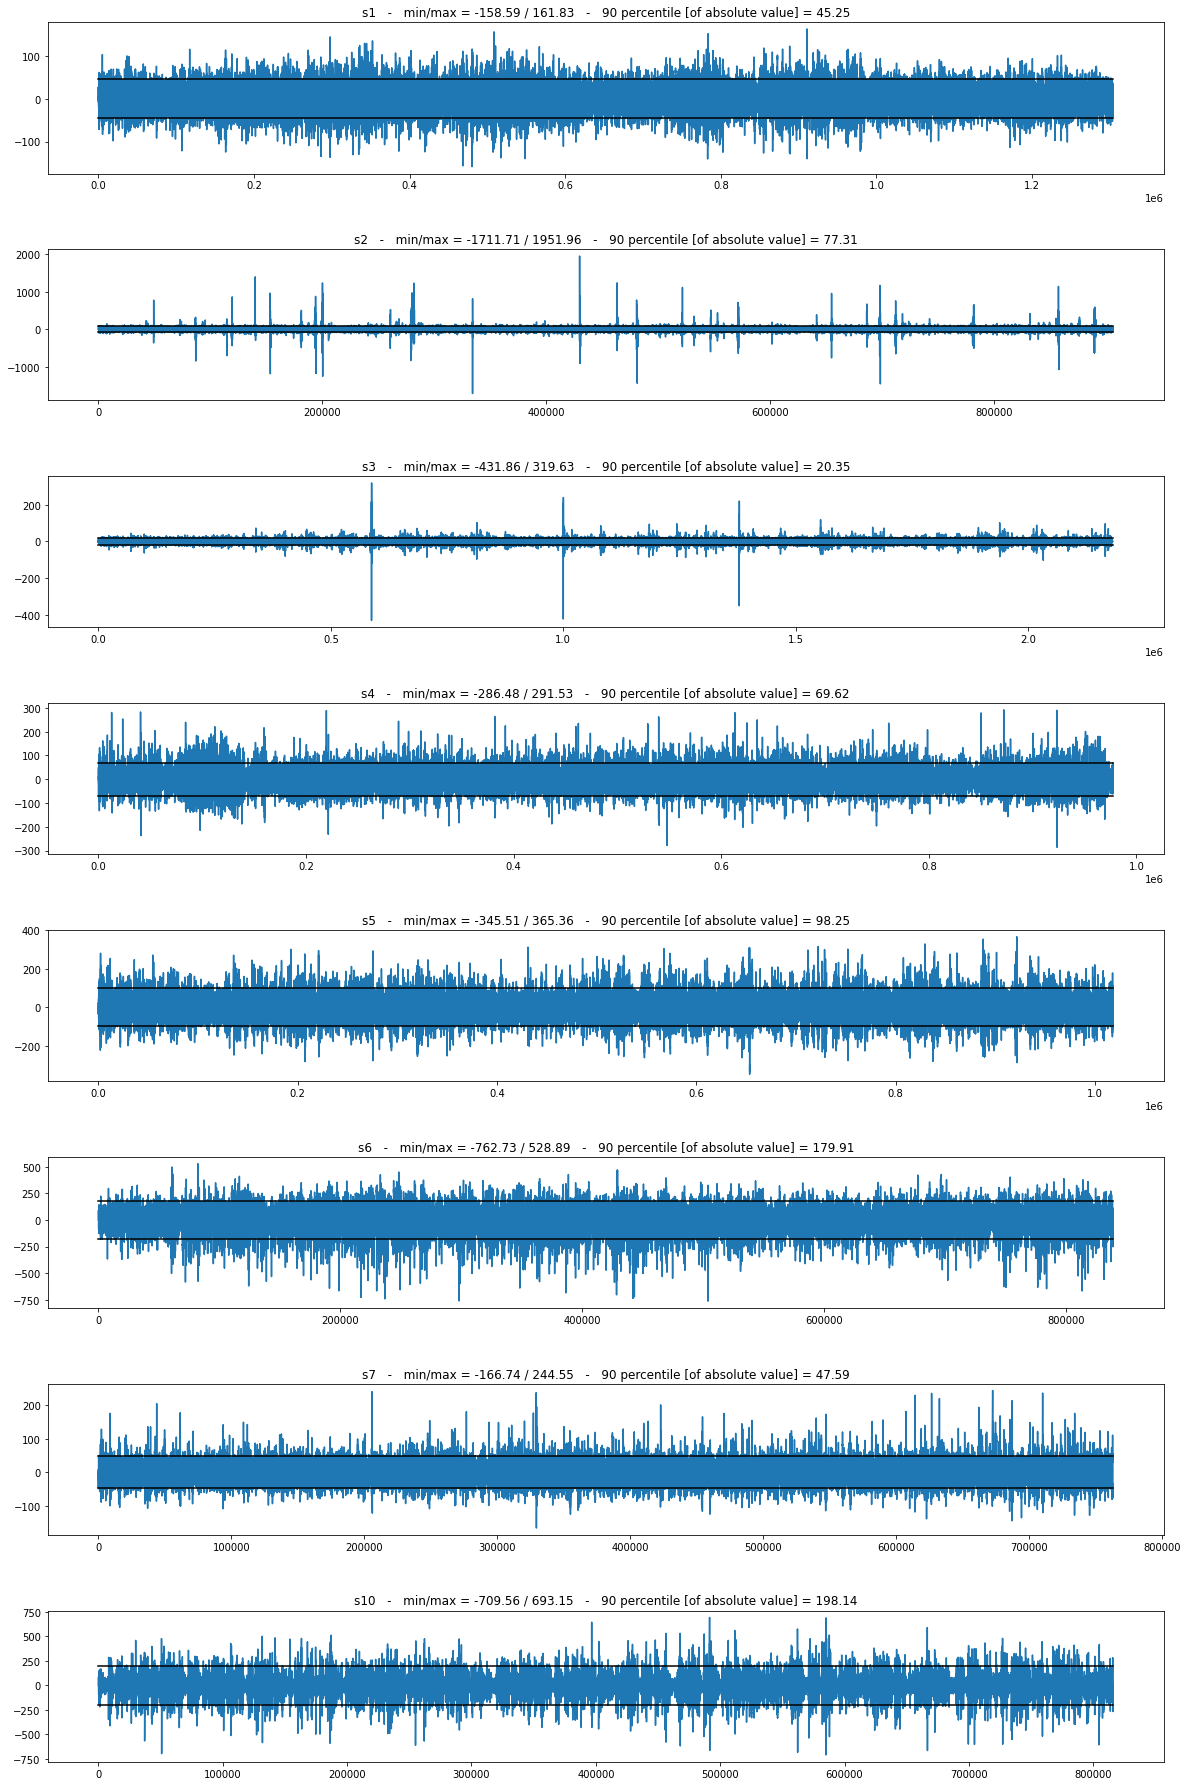

In [4]:
plt.figure(figsize = (20, len(sessions) * 4))
plt.subplots_adjust(hspace = 0.5)
for idx, s in enumerate(sessions):
    c = data[s]['data'].T[0]
#     c = (c - c.mean()) / c.std()
    plt.subplot(len(sessions), 1, idx + 1)
    plt.plot(c)
    lim = np.percentile(np.abs(c), 90)
    plt.plot([0, len(c)], [ lim,  lim], c = 'black')
    plt.plot([0, len(c)], [-lim, -lim], c = 'black')
    plt.title(f'{s}   -   min/max = {round(c.min(), 2)} / {round(c.max(), 2)}   -   90 percentile [of absolute value] = {round(lim, 2)}')
plt.show()
data = 0

### After investigation, decide to discard sessions 2, 3.
8 and 9 use different sampling frequency, and are as such discarded as well.

In [5]:
sessions = ['s1', 's4', 's5', 's6', 's7', 's10']
data = dl.get_fcx2(sessions)

In [6]:
def get_as_array(session):
    arrs = data[session]['data']
    mn = arrs.mean(0).reshape((1, -1))
    st = arrs.std (0).reshape((1, -1))
    arrs -= mn
    arrs /= st
    return arrs

Xs = [
    get_as_array(s)
    for s in sessions
]

data = 0

In [7]:
n_c_max = max(Xs, key = lambda X: X.shape[1]).shape[1]
n_c_max

172

In [8]:
n_channelss = [X.shape[1] for X in Xs]

def pad_with_zeros(X):
    zeros = np.zeros((X.shape[0], n_c_max - X.shape[1]))
    out = np.concatenate([X, zeros], 1)
    return out

Xs = [pad_with_zeros(X) for X in Xs]

In [9]:
[X.shape for X in Xs], n_channelss

([(1303952, 172),
  (977418, 172),
  (1017999, 172),
  (838999, 172),
  (762999, 172),
  (815892, 172)],
 [73, 66, 172, 91, 110, 110])

In [10]:
t_in  = 100
t_out = 10

train_frac = 0.5
val_frac   = 0.2

train_maxs = np.array([
    int(X.shape[0] * train_frac) - t_in - t_out
    for X in Xs
])

val_ranges = np.array([
    (train_max + t_in + t_out, train_max + int(X.shape[0] * val_frac) - t_in - t_out)
    for train_max, X in zip(train_maxs, Xs)
])

test_mins = np.array([
    val_range[1] + t_in + t_out
    for val_range in val_ranges
])

np.concatenate([
    train_maxs.reshape((1, -1)),
    val_ranges.T,
    test_mins.reshape((1, -1)),
])

array([[651866, 488599, 508889, 419389, 381389, 407836],
       [651976, 488709, 508999, 419499, 381499, 407946],
       [912546, 683972, 712378, 587078, 533878, 570904],
       [912656, 684082, 712488, 587188, 533988, 571014]])

In [11]:
n_validation_per_channel = 10000

def random_subset(idxs, n):
    np.random.shuffle(idxs)
    return idxs[:n]

idxs = [
    random_subset(np.arange(lo, hi), n_validation_per_channel)
    for lo, hi in val_ranges
]
[r.shape for r in idxs], idxs

([(10000,), (10000,), (10000,), (10000,), (10000,), (10000,)],
 [array([851897, 781247, 761160, ..., 744893, 777503, 668376]),
  array([628853, 633137, 533823, ..., 529016, 603407, 676142]),
  array([609347, 654083, 570606, ..., 697272, 661557, 650856]),
  array([502922, 566059, 471006, ..., 563548, 457958, 439544]),
  array([396277, 443961, 395828, ..., 477815, 501661, 402948]),
  array([410093, 434840, 461024, ..., 539962, 414286, 411706])])

In [12]:
Xs[0].shape

(1303952, 172)

In [13]:
X_val = np.concatenate([
    np.stack([
        np.concatenate([
            X[idxs[idx] + t],
            np.array(len(idxs[idx]) * [n_channels]).reshape((-1, 1))
        ], 1)
        for t in range(t_in) 
    ], 1)
    for idx, (n_channels, X) in enumerate(zip(n_channelss, Xs))
])

Y_val = np.concatenate([
    np.stack([
        X[idxs[idx] + t + t_in]
        for t in range(t_out) 
    ], 1)
    for idx, X in enumerate(Xs)
])

X_val.shape, Y_val.shape

((60000, 100, 173), (60000, 10, 172))

In [14]:
n_sessions = len(sessions)
train_idxs = [
    np.arange(train_max)
    for train_max in train_maxs
]

def get_random_train_idxs(train_range, n):
    np.random.shuffle(train_range)
    return train_range[:n]


def training_data_generator(
    batch_size,
    steps_per_epoch,
    epochs
):
    
    for _ in range(steps_per_epoch * epochs):
        counts = pd.Series(
            np.random.randint(n_sessions, size = batch_size)
        ).value_counts()

        idxs = [
            get_random_train_idxs(train_idxs[idx], n)
            for idx, n in enumerate(counts)
        ]

        x = np.concatenate([
            np.stack([
                np.concatenate([
                    X[idx + t], 
                    np.array([n_channels] * len(idx)).reshape((-1, 1))
                ], 1)
                for t in range(t_in) 
            ], 1)
            for n_channels, idx, X in zip(n_channelss, idxs, Xs)
        ])

        y = np.concatenate([
            np.stack([
                X[idx + t + t_in]
                for t in range(t_out) 
            ], 1)
            for idx, X in zip(idxs, Xs)
        ])
        
        
        yield (x, y)

In [15]:
class Splitter(layers.Layer):
    def call(self, inputs):
        signals = inputs[:,:,:-1]
        labels  = tf.cast(inputs[:, :t_out, -1], tf.int32)
        return signals, labels
    
class Combiner(layers.Layer):
    def call(self, inputs):
        outputs, labels = inputs
        
        idxs_for_mask = tf.ones(tf.shape(outputs), dtype = tf.int32) * np.arange(outputs.shape[-1])
        lims_for_mask = tf.repeat(tf.expand_dims(labels, 2), outputs.shape[-1], 2)
        return outputs * tf.cast(idxs_for_mask < lims_for_mask, tf.float32)
    
input_layer = layers.Input((t_in, n_c_max + 1))
signals, labels = Splitter()(input_layer)

encoder = layers.Bidirectional(
    layers.LSTM(64)
)(signals)

repeater = layers.RepeatVector(t_out)(encoder)

decoder1 = layers.LSTM(128, return_sequences = True)(repeater)
decoder2 = layers.Bidirectional(
    layers.LSTM(64, return_sequences = True)
)(decoder1)

regressor = layers.Dense(n_c_max)(decoder2)
cleaner = Combiner()([regressor, labels])

model = keras.Model(input_layer, cleaner)
model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 173)]   0                                            
__________________________________________________________________________________________________
splitter (Splitter)             ((None, 100, 172), ( 0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128)          121344      splitter[0][0]                   
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 10, 128)      0           bidirectional[0][0]              
______________________________________________________________________________________________

In [ ]:
batch_size      = 2048
steps_per_epoch = 50
epochs          = 50

model.fit(
    x = training_data_generator(batch_size, steps_per_epoch, epochs),
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = (X_val, Y_val)
)

Epoch 1/50
50/50 [==============================] - 25s 430ms/step - loss: 0.4769 - val_loss: 0.3112
Epoch 2/50
50/50 [==============================] - 18s 359ms/step - loss: 0.2834 - val_loss: 0.2469
Epoch 3/50
50/50 [==============================] - 18s 357ms/step - loss: 0.2258 - val_loss: 0.2069
Epoch 4/50
50/50 [==============================] - 18s 356ms/step - loss: 0.1887 - val_loss: 0.1789
Epoch 5/50
50/50 [==============================] - 18s 356ms/step - loss: 0.1648 - val_loss: 0.1594
Epoch 6/50
50/50 [==============================] - 18s 356ms/step - loss: 0.1474 - val_loss: 0.1463
Epoch 7/50
50/50 [==============================] - 18s 360ms/step - loss: 0.1345 - val_loss: 0.1353
Epoch 8/50
50/50 [==============================] - 18s 359ms/step - loss: 0.1258 - val_loss: 0.1274
Epoch 9/50
50/50 [==============================] - 18s 356ms/step - loss: 0.1186 - val_loss: 0.1224
Epoch 10/50
50/50 [==============================] - 18s 356ms/step - loss: 0.1130 - val_lo